Machine learning model that predicts future annual sales

Import of necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import datetime

import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

Load data

In [2]:
ventas= pd.read_csv(r'C:\Users\Lina_\OneDrive\Escritorio\ProyectoFinal\Semana 3\Datasets\VentasMensuales.csv', sep=';')

Data preprocessing

In [3]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   616 non-null    object 
 1   ventas  616 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.8+ KB


View the data

In [4]:
ventas.head(10)

,fecha,ventas
0,2017-01-05,396.90
1,2017-01-06,916.38
2,2017-01-07,1351.90
3,2017-01-08,709.58
4,2017-01-09,673.79
5,2017-01-10,1434.87
6,2017-01-11,2776.16
7,2017-01-12,2234.58
8,2017-01-13,2505.58
9,2017-01-14,1112.69


In [5]:
def transformData(data):
    # We create a copy of the original dataset 
    monthly_data = data.copy()

    # Drop the day indicator from the date column
    monthly_data.fecha = monthly_data.fecha.apply(lambda x: str(x)[:-3])

    # Sum sales per month 
    monthly_data = monthly_data.groupby('fecha')['ventas'].sum().reset_index()

    # We change the data type to date
    monthly_data.fecha = pd.to_datetime(monthly_data.fecha)
    
    # Divide by 1000 to put the '.' in the right place
    monthly_data.ventas /= 1000

    # We eliminate sales data that is only from one day, since it generates noise in the prediction
    monthly_data.drop(monthly_data[(monthly_data['fecha'] == '2018-09-01')].index, inplace=True)
    monthly_data.drop(monthly_data[(monthly_data['fecha'] == '2016-12-01')].index, inplace=True)

    return monthly_data

ventasM = transformData(ventas)

In [6]:
#Verify the changes
ventasM

,fecha,ventas
0,2016-09-01,0.26736
1,2016-10-01,49.50766
3,2017-01-01,120.31287
4,2017-02-01,247.30302
5,2017-03-01,374.34430
6,2017-04-01,359.92723
7,2017-05-01,506.07114
8,2017-06-01,433.03860
9,2017-07-01,498.03148
10,2017-08-01,573.97168


EDA

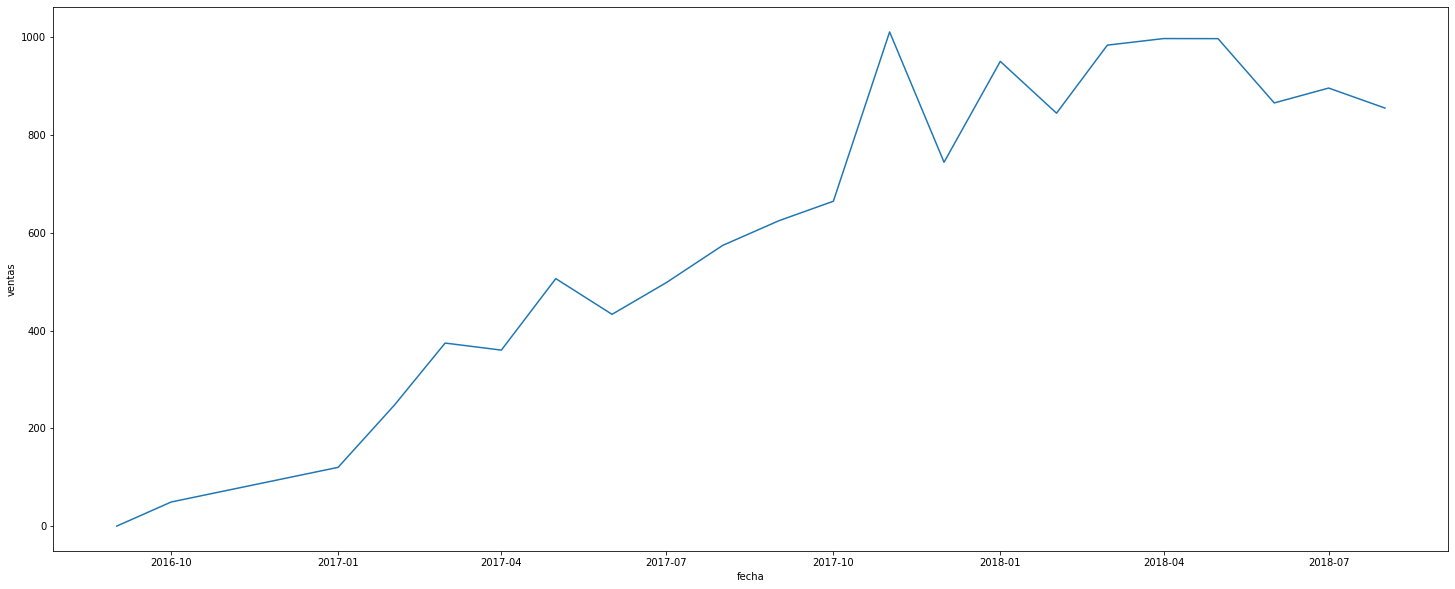

In [7]:
#We graph the data frame information to visualize the behavior of the data
plt.figure(figsize=(25,10))
sns.lineplot(x = 'fecha', y = 'ventas', data = ventasM)
plt.show()

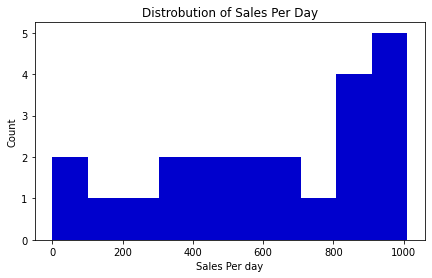

In [8]:
def sales_per_day():
    fig, ax = plt.subplots(figsize=(7,4))
    plt.hist(ventasM.ventas, color='mediumblue')
    
    ax.set(xlabel = "Sales Per day",
           ylabel = "Count",
           title = "Distrobution of Sales Per Day")
    
sales_per_day()

In [9]:
# Average monthly sells

# Overall
avg_monthly_sells = ventasM.ventas.mean()
print(f"Overall average monthly ventas: ${avg_monthly_sells}")

# Last 12 months (this will be the forecasted ventas)
avg_monthly_sells_12month = ventasM.ventas[-12:].mean()
print(f"Last 12 months average monthly ventas: ${avg_monthly_sells_12month}")

Overall average monthly ventas: $617.7949000000007
Last 12 months average monthly ventas: $869.0593716666682


c:\Users\Lina_\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Lina_\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


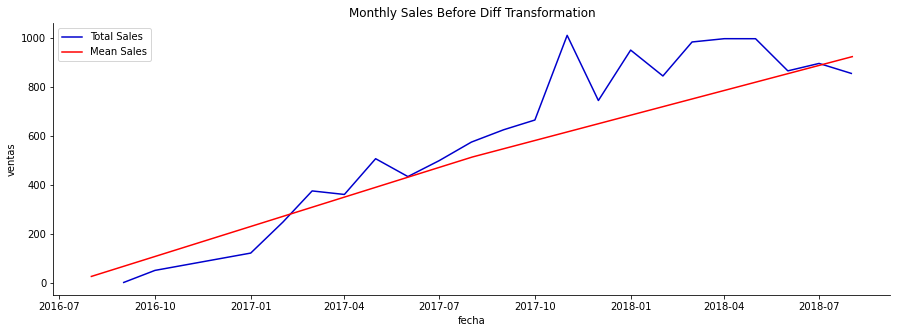

In [10]:
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.fecha.dt.year)[y_col].mean().reset_index()
    second.fecha = pd.to_datetime(second.fecha, format='%Y')
    sns.lineplot((second.fecha + datetime.timedelta(7*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "fecha",
           ylabel = "ventas",
           title = title)
    
    sns.despine()

time_plot(ventasM, 'fecha', 'ventas', 'Monthly Sales Before Diff Transformation')

In [11]:
#We create a copy dataframe where we will create a column that calculates the difference in monthly sales
def get_diff(data):
    data['diferenciaVentas'] =  data.ventas.diff()
    data = data.dropna()
    return data

stationary_df = get_diff(ventasM)

In [12]:
#We verify that the changes have been applied
stationary_df

,fecha,ventas,diferenciaVentas
1,2016-10-01,49.50766,49.24030
3,2017-01-01,120.31287,70.80521
4,2017-02-01,247.30302,126.99015
5,2017-03-01,374.34430,127.04128
6,2017-04-01,359.92723,-14.41707
7,2017-05-01,506.07114,146.14391
8,2017-06-01,433.03860,-73.03254
9,2017-07-01,498.03148,64.99288
10,2017-08-01,573.97168,75.94020
11,2017-09-01,624.40169,50.43001


c:\Users\Lina_\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Lina_\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


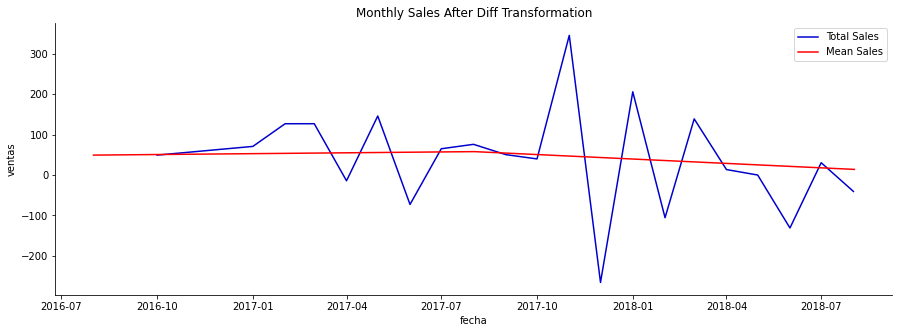

In [13]:
time_plot(stationary_df, 'fecha', 'diferenciaVentas', 'Monthly Sales After Diff Transformation')

c:\Users\Lina_\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


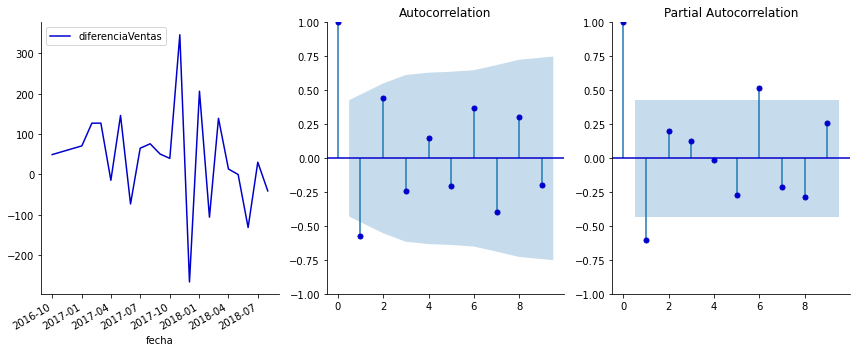

In [14]:
# Observing lags
def plots(data, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data.set_index('fecha').drop('ventas', axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(12, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, lags=9)

Preparing Dataset Modeling

In [15]:
#We create a datafrae that will store the retrospective period of the model which is 4 months
#create dataframe for transformation from time series to supervised
def generate_supervised(data):

    supervised_df = data.copy()
    #create column for each lag
    for i in range(1, 5):
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df['diferenciaVentas'].shift(i)

    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)

    return supervised_df

modelo = generate_supervised(stationary_df)

In [16]:
modelo

,fecha,ventas,diferenciaVentas,lag_1,lag_2,lag_3,lag_4
0,2017-04-01,359.92723,-14.41707,127.04128,126.99015,70.80521,49.24030
1,2017-05-01,506.07114,146.14391,-14.41707,127.04128,126.99015,70.80521
2,2017-06-01,433.03860,-73.03254,146.14391,-14.41707,127.04128,126.99015
3,2017-07-01,498.03148,64.99288,-73.03254,146.14391,-14.41707,127.04128
4,2017-08-01,573.97168,75.94020,64.99288,-73.03254,146.14391,-14.41707
5,2017-09-01,624.40169,50.43001,75.94020,64.99288,-73.03254,146.14391
6,2017-10-01,664.21943,39.81774,50.43001,75.94020,64.99288,-73.03254
7,2017-11-01,1010.27137,346.05194,39.81774,50.43001,75.94020,64.99288
8,2017-12-01,743.91417,-266.35720,346.05194,39.81774,50.43001,75.94020
9,2018-01-01,950.03036,206.11619,-266.35720,346.05194,39.81774,50.43001


Model Creation

    Train test split

In [17]:
def tts(data):
    data = data.drop(['ventas','fecha'],axis=1)
    train, test = data[0:-7].values, data[-7:].values
    
    return train, test

train, test = tts(modelo)

In [18]:
print(train.shape)
print(test.shape)

(10, 5)
(7, 5)


In [19]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

    Modeling Functions

In [20]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [21]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv(r'C:\Users\Lina_\OneDrive\Escritorio\ProyectoFinal\Semana 3\Datasets\VentasMensuales2017.csv', sep=';')
    original_df.fecha = original_df.fecha.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('fecha')['ventas'].sum().reset_index()
    original_df.fecha = pd.to_datetime(original_df.fecha)
    original_df.ventas /= 1000
    # We eliminate sales data that is only from one day, since it generates noise in the prediction
    original_df.drop(original_df[(original_df['fecha'] == '2018-09-01')].index, inplace=True)
    original_df.drop(original_df[(original_df['fecha'] == '2016-12-01')].index, inplace=True)
    return original_df

In [22]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_date = list(original_df[-10:].fecha)
    act_sales = list(original_df[-10:].ventas)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['fecha'] = sales_date[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [23]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.ventas[-7:], unscaled_df.pred_value[-7:]))
    mae = mean_absolute_error(original_df.ventas[-7:], unscaled_df.pred_value[-7:])
    r2 = r2_score(original_df.ventas[-7:], unscaled_df.pred_value[-7:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [24]:
def plot_results(results, original_df, model_name):

       fig, ax = plt.subplots(figsize=(15,5))
       sns.lineplot(original_df.fecha, original_df.ventas, data=original_df, ax=ax, 
                     label='Original', color='mediumblue')
       sns.lineplot(results.fecha, results.pred_value, data=results, ax=ax, 
                     label='Predicted', color='Red')

       print('-----Results-----')
       print(results)

       ax.set(xlabel = "fecha",
              ylabel = "ventas",
              title = f"{model_name} Sales Forecasting Prediction")

       ax.legend()

       sns.despine()

In [25]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

    Predict to model Linear Regression

RMSE: 84.5569100630031
MAE: 65.85707428571428
R2 Score: 0.7676664124707893
-----Results-----
   pred_value      fecha
0         489 2017-04-01
1         485 2017-05-01
2         601 2017-06-01
3         485 2017-07-01
4         662 2017-08-01
5         870 2017-09-01
6         827 2017-10-01


c:\Users\Lina_\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Lina_\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


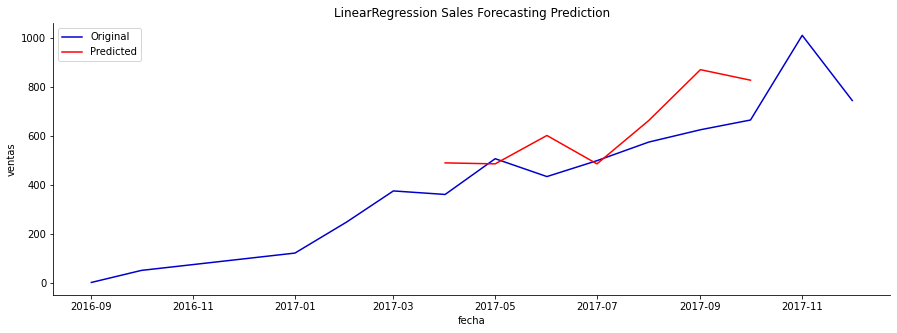

In [27]:
regression = run_model(train, test, LinearRegression(), 'LinearRegression')

Deploy with streamlit

In [28]:
import joblib
joblib.dump(regression, 'regressionModel')

['regressionModel']